In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Lasso:
    def __init__(self, alpha=0.1, maxiter=100):
        self.alpha = alpha
        self.maxiter = maxiter
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2*np.linalg.eig(X.T@X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            v = z + (X.T @ res) / L
            w_new = self._soft_threshold(v,  self.alpha / L)
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
        
    def _soft_threshold(self, y, alpha):
        return np.sign(y) * np.maximum(np.abs(y) - alpha, 0.0)

In [3]:
class GroupLasso:
    def __init__(self, group_ids, alpha=1e-3, eta=1e-1, maxiter=100):
        self.alpha = alpha
        self.eta = eta
        self.maxiter = maxiter
        self.group_ids = group_ids
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2 * np.linalg.eig(X.T @ X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            
            #print('loss:', np.mean(res**2))
            v = z + (X.T @ res) / L * self.eta
            #print(self.alpha * self.eta / L)
            w_new = self._proximal_operator(v,  self.alpha * self.eta )
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
        
    def _proximal_operator(self, v, thresh):
        result_w = np.zeros_like(self.w).astype(np.float64)
        for group_id in self.group_ids:
            # 該当するgroupのみ係数を抽出
            group_coef_idx = self.group_ids == group_id
            group_coef = v[group_coef_idx]
            
            # L2ノルムの計算
            group_norm = np.linalg.norm(group_coef, 2)
            
            # soft_threshold関数
            if group_norm == 0:
                multiplier = 0
            else:
                #print(group_norm)
                multiplier = np.maximum(0, 1 -  thresh / group_norm)
            
            result_w[group_coef_idx] = multiplier * group_coef
            
        return result_w

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


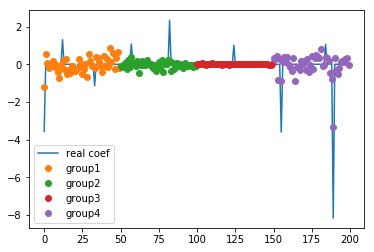

In [4]:
#np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)
group_ids = np.array([0 for i in range(50)] + [1 for i in range(50)] +  [2 for i in range(50)] + [3 for i in range(50)])
eta = 0.2    # 学習率
alpha = 0.1
group_lasso = GroupLasso(group_ids=group_ids, alpha=alpha, eta=eta, maxiter=1000)
group_lasso.fit(X, y)
plt.plot(coef, '-', label='real coef')
plt.plot([i for i in range(0, 50)], group_lasso.w[:50], 'o', label='group1')
plt.plot([i for i in range(50, 100)], group_lasso.w[50:100], 'o', label='group2')
plt.plot([i for i in range(100, 150)], group_lasso.w[100:150], 'o', label='group3')
plt.plot([i for i in range(150, 200)], group_lasso.w[150:200], 'o', label='group4')
plt.legend()
plt.show()

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


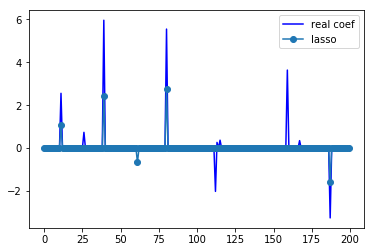

In [5]:
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)

alpha = 0.1
lasso = Lasso(alpha=100, maxiter=30000)
lasso.fit(X, y)

# compare
plt.plot(coef, '-b', label='real coef')
plt.plot(lasso.w, '-o', label='lasso')
plt.legend()
plt.show()

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


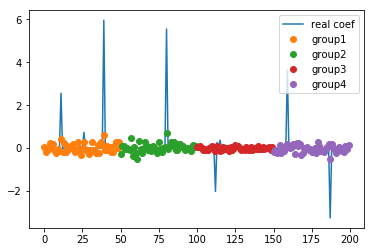

In [6]:
group_ids = np.array([0 for i in range(50)] + [1 for i in range(50)] +  [2 for i in range(50)] + [3 for i in range(50)])
eta = 0.2    # 学習率
group_lasso = GroupLasso(group_ids=group_ids, alpha=eta)
group_lasso.fit(X, y)
plt.plot(coef, '-', label='real coef')
plt.plot([i for i in range(0, 50)], group_lasso.w[:50], 'o', label='group1')
plt.plot([i for i in range(50, 100)], group_lasso.w[50:100], 'o', label='group2')
plt.plot([i for i in range(100, 150)], group_lasso.w[100:150], 'o', label='group3')
plt.plot([i for i in range(150, 200)], group_lasso.w[150:200], 'o', label='group4')
plt.legend()
plt.show()

In [7]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

data = load_boston()

# 学習の効率化のため、各説明変数は正規化する
x = StandardScaler().fit_transform(data.data)
y = data.target


In [8]:
pd.DataFrame(data.data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [9]:
group_ids = np.array([0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6, 6])

In [10]:
alpha = 0.5
eta = 0.2
model = GroupLasso(group_ids=group_ids, alpha=alpha, eta=eta)
model.fit(x, y)

In [11]:
print(model.w)

[-0.          0.         -0.          0.         -0.          0.5609051
 -0.26914494  0.15802042 -0.         -0.         -0.          0.21448882
 -0.48673681]


In [12]:
pd.DataFrame(np.concatenate([group_ids.reshape(1, -1), model.w.reshape(1, -1)])).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,1.0,2.0,2.0,3.000000,3.000000,3.00000,4.0,4.0,5.0,6.000000,6.000000
1,-0.0,0.0,-0.0,0.0,-0.0,0.560905,-0.269145,0.15802,-0.0,-0.0,-0.0,0.214489,-0.486737
